# Folosirea validarii încrucișate

<div>
  <h3>k-fold cross-validation</h3>
  <ul>
    <li>Impartim setul de date in k sub-seturi</li>
    <li>Apoi
      <ul>
        <li>Iteram de k ori</li>
        <li>luam k-1 seturi ca set de training</li>
        <li>restul de 1 setul de validare</li>
        <li>antrenam regresorul</li>
        <li>lil_err = ...</li>
      </ul>
    </li>
    <li>err = Suma de li_err</li>
  </ul>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_1545/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def read_data(filePath: str):
    df = pd.read_csv(filePath)
    df = df.dropna()
    return df

def splitDatasInKFolds(filePath:str, k:int):
    df = read_data(filePath)
    size = df.shape[0]
    arr = np.array_split(range(size),k)
    input_sets = [[df["Economy..GDP.per.Capita."].iloc[index] for index in indexes ] for indexes in arr]
    output_sets = [[df["Happiness.Score"].iloc[index] for index in indexes ] for indexes in arr]
    return input_sets, output_sets

def getErrors(computedOutputValues, groundTruthValues):
    err = 0.0
    for cov,gtv in zip(computedOutputValues, groundTruthValues):
        err = (gtv - cov)**2
    err /= len(computedOutputValues)
    return err

from sklearn.linear_model import SGDRegressor
def getAndTrainReggressor(filePath:str, k:int):
    input_sets,output_sets = splitDatasInKFolds(filePath, k)
    regressor = SGDRegressor()
    errors = []
    for i in range(k):
        validation_input_set, validation_output_set = input_sets[i],output_sets[i]
        training_input_set = []
        training_output_set = []
        for j in range(k):
            if j != i:
                training_input_set += input_sets[j]
                training_output_set += output_sets[j]
        
        xx = [[el] for el in training_input_set]
        regressor.partial_fit(xx, training_output_set)    
        
        xx_test = [[el] for el in validation_input_set]
        computed_output_values = regressor.predict(xx_test)

        errors.append(getErrors(computed_output_values, validation_output_set))
    
    return regressor, errors

In [3]:
def plotToolRegressor(filePath:str, k:int):

    df = read_data(filePath)

    input_sets = df["Economy..GDP.per.Capita."]
    output_sets = df["Happiness.Score"]

    regressor, err = getAndTrainReggressor(filePath, k)
    w0, w1 = regressor.intercept_, regressor.coef_[0]

    print("f(x) = {} + {}*x".format(w0,w1))

    print("Eroare: {}".format(err))

    noOfPoints = 1000
    xref = []
    val = min(input_sets)
    step = (max(input_sets) - min(input_sets)) / noOfPoints
    for i in range(1, noOfPoints):
        xref.append(val)
        val += step
    yref = [w0 + w1 * el for el in xref] 

    fix,axes = plt.subplots()

    axes.plot(input_sets, output_sets, 'ro', label = 'training data')  
    axes.plot(xref, yref, 'b-', label = 'learnt model')                  
    axes.set_title('train data and the learnt model')
    axes.set_xlabel('GDP')
    axes.set_ylabel('happiness')
    axes.legend()
    plt.show()


f(x) = [2.77304334] + 2.590896250506737*x
Eroare: [0.2867745966869914, 0.18810808811580892, 0.03964508005004986, 0.019893764206118335, 0.031585836812198564, 0.015585615977129, 0.027633313500949965, 0.0013876699914177571, 0.0003768778550229491]


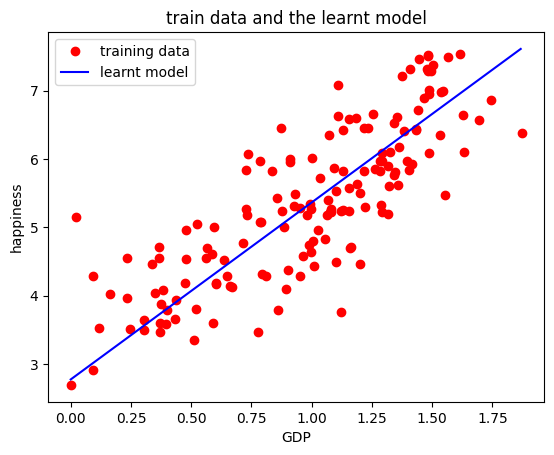

In [4]:
plotToolRegressor('datas/2017.csv',9)

# Investigarea diferitelor funcții de loss

- **Squared Error** (squared_error)
    - The ordinary least squares is the square of the difference between the actual value and predicted value.
    - It tends to penalize model more and more for larger differences thereby giving more weight to outliers

- **Huber** (huber)
    - The mean squared error (MSE) or squared error gives too much importance to outliers and Mean Average error (MAE) (here instead of squaring we take absolute value of errors) gives equal weightage to all points
    - Huber loss combines MSE and MAE to give best of both wold- it is quadratic(MSE) when the error is small else MAE

- **Epsilon Insensitive** (epsilon_insensitive)
    - The value of epsilon determines the distance within which errors are considered to be zero . The loss function ignores error which are less than or equal to epsilon value by treating them zero.
    - Thus the loss function effectively forces the optimizer to find such a hyperplane that a tube of width epsilon around this hyperplane will contain all the datapoints.

In [5]:
def getTrainingAndValidationSet1(df_world_happiness):
    dataSize = df_world_happiness.shape[0]
    trainingIndexSet = np.random.choice(range(dataSize),size=int(0.8 * dataSize),replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet] 

    trainingInputSet = [df_world_happiness["Economy..GDP.per.Capita."].iloc[index] for index in trainingIndexSet ]
    trainingOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in trainingIndexSet ]

    validationInputSet = [df_world_happiness["Economy..GDP.per.Capita."].iloc[index] for index in validationIndexSet ]
    validationOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in validationIndexSet ]
    
    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet

def getRegressorTool(df_world_happiness, loss_type):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSet1(df_world_happiness)
    xx = [[el] for el in trainingInputSet]
    regressor = SGDRegressor(loss=loss_type)
    regressor.fit(xx, trainingOutputSet)
    return regressor

In [19]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error


df = read_data('datas/2017.csv')

_,_,validationInputSet,validationOutputSet = getTrainingAndValidationSet1(df)

for error in SGDRegressor.loss_functions.keys():
    print("Loss function: ",error)
    regressor = getRegressorTool(df,error)
    computedOutputSet = regressor.predict([[el] for el in validationInputSet])
    print("R squared: ",metrics.r2_score(y_true=validationOutputSet, y_pred=computedOutputSet))

Loss function:  squared_error
R squared:  0.7597721020034564
Loss function:  huber
R squared:  0.5017486194080154
Loss function:  epsilon_insensitive
R squared:  0.7548541711237298
Loss function:  squared_epsilon_insensitive
R squared:  0.759980800918409


<div style='width: 100%; display: flex; align-items: center;'>
    <div style='width: 60%;'>
        <b>Ce se întîmplă în cazul clasificarii binare daca se modifică pragul de decizie din 0.5 în alte valori. Cum se poate aprecia calitatea clasificatorului pentru diferite valori ale pragului?</b>
        <ul>
            <li>Functia sigmoid este uniform distribuita cu valori in intervalul [0,1]</li>
            <li>Daca modificam pragul de decizie din 0.5 in alte valori vom influenta alegerea raspunsului astfel:
                <ul>
                    <li>Daca scadem valoarea, label-ul 2 are mai multe sanse de a fi ales, in timp ce label-ul 1 are mai putine sanse</li>
                    <li>Daca crestem valoarea, label-ul 2 are mai putine sanse de a fi ales, in timp ce label-ul 1 are mai multe sanse</li>
                </ul>
            </li>
        </ul>
    </div>
    <div style='width: 40%; background-color: white'>
        <img style='width: 100%;' src='images/sigmoid.png'>
    </div>
</div>
